# Train from scratch
Here, we show how to train a network from scratch using this code.  

Before training, first prepare all the **VASP structures** used and put them in a folder. Then prepare a **csv file** for each dataset that contains the file name and target quantity values for each sample. The training set and the validation set are required, and the test set is optional.  

Load all Python modules used in this tutorial

In [1]:
from ASGCNN.Encoder import Encoder_structure, Encoder_element, Encoder_edge, Graph_data_loader
from ASGCNN.Model import ASGCNN
from ASGCNN.Trainer import Trainer, setup_seed

import zipfile
import pandas as pd

The **tqdm.notebook** is used to show progress bar, if you are not using jupyter notebook or there is problems when using tqdm.notebook, go into Trainer and Encoder scripts, annotation "**from tqdm.notebook import tqdm as tqdm**" and use "**from tqdm import tqdm**". Or use the parameter **disable=True** where tqdm is called to close tqdm.

# Create dataset
Using multiple **Encoder**s in **ASGCNN.Encoder** script to build the database.

## Encoder_structure
First, define **Encoder_structure**s for structure to graph transformation.  

The key parameter for **Encoder_structure** is the **cutoff radius**. The cutoff radius for neighbor atom finding is set to **3.36 by default**, which ensures atoms on our **unrelaxed** and **lattice-fixed** slab structures can only bond to their first and second near neighbor atoms, and adsorbates can only bond to adsorption sites. You should determine this value based on the system you are studying.  

For further clarification about **Encoder_structure**, refer to:

In [ ]:
help(Encoder_structure.__init__)

Let us defind a **Encoder_structure** for slab structure:

In [3]:
Es_slab = Encoder_structure(cutoff=3.36)

As for the creation of **adsorbate-site graph**s is done by deleting atoms. This is achieved by using the **element_restrict** parameter in **Encoder_structure**; by setting this to the elements of adsorbates, substrate atoms that do not bond to adsorbate atoms will be deleted, and only adsorbate and site atoms will be used to create the graph.  

Now define a **Encoder_structure** for vasp input file to adsorbate-site graph transformation:

In [4]:
Es_adsb = Encoder_structure(cutoff=3.36, element_restrict={'N', 'H'})

## Encoder_element
After defining the **Encoder_structure** for structure-to-graph transformation, define the encoder for encoding graph node and edge features (**Encoder_element** and **Encoder_edge**).   

Let us check out **Encoder_element** first.   

Node features provided by the current code can broadly classify into **integers** and **floating-point** values. They are all rendered in **one-hot** encoding by default.  The **length** of the integer encoding is determined by the **number of integers** contained in the feature, and the **length** of the floating-point one-hot encoding is determined by the **numerical_feature_length** parameter.  

You need to pass a **list of the elements** contained in the database, and then the encoder automatically calculates the **one-hot** feature based on the numerical value of the contained element features.  

For further clarification about **Encoder_structure**, refer to:

In [ ]:
help(Encoder_element.__init__)

All available elemental features can be viewed in file **Element_feature.csv**. You can also modify or add features to this table.

In [6]:
df = pd.read_csv(r'ASGCNN/Element_feature.csv', index_col=0)
df.columns

Index(['group', 'period', 'atomic number', 'radius', 'electronegativity',
       'ionization', 'affinity', 'volume', 'weight', 'melting', 'boiling',
       'density', 'Zeff', 'polarizability', 'resistivity', 'fusion',
       'vaporization', 'atomization', 'capacity', 'valence', 'd-electron'],
      dtype='object')

In [7]:
df.head()

,group,period,atomic number,radius,electronegativity,ionization,affinity,volume,weight,melting,...,density,Zeff,polarizability,resistivity,fusion,vaporization,atomization,capacity,valence,d-electron
Element,,,,,,,,,,,,,,,,,,,,,
H,1,1,1,0.32,2.20,13.598,0.754,14.10,1.007940,-259.34,...,0.0899,1.00,0.6668,1000.00,0.0586,0.4490,217.57,14.304,1.0,0
He,18,1,2,0.31,NaN,24.587,-0.500,31.80,4.002602,-272.20,...,0.1785,1.34,0.2050,NaN,NaN,0.0829,NaN,5.193,NaN,0
Li,1,2,3,1.23,0.98,5.392,0.618,13.00,6.941000,180.50,...,0.5340,1.26,24.3000,9.47,3.0000,134.6800,160.67,3.582,NaN,0
Be,2,2,4,0.89,1.57,9.322,-0.500,4.88,9.012182,1287.00,...,1.8477,1.66,5.6000,3.70,11.7200,294.6600,326.35,1.825,NaN,0
B,13,2,5,0.82,2.04,8.298,0.279,4.68,10.811000,2075.00,...,2.3100,1.56,3.0300,NaN,22.1800,480.0000,573.21,1.026,NaN,0


Now define **Encoder_element**s for slab graph and adsorbate-site graph respectively and give them different node features. The dault value of parameter **elements** fits our work, and we have omitted its definition here.

In [8]:
En_adsb = Encoder_element(
    #elements=['Fe',......]
    features=['group', 'period', 'electronegativity', 'radius', 'density', 'Zeff'])

En_slab = Encoder_element(
    #elements=['Fe',......]
    features=['group', 'period', 'electronegativity', 'radius', 'affinity', 'weight'])

Once the feature encoder is defined, the **feature_lentgh_total** attribute is called to see the total length of the feature. This variable is needed to set parameters for the network model.

In [9]:
En_adsb.feature_lentgh_total

60

In [10]:
En_slab.feature_lentgh_total

60

## Encoder_edge
Then, define **Encoder_edge** for edge feature generation.

We define **four edge feature** for usage:
- **'radiusg'**: Atomic distance expanded by Gaussian basis function
- **'radiusb'**: Atomic distance expanded by RadialBessel basis function
- **'bond'**: A single number 1 for all boning edge
- **'category'**: The type of bond obtained according to the type of bonding atom, the parameter **vertice_typs** is required to guide the type of atom
- **'distance'**: The graph distance from the edge to the specified node, which needs to be specified with parameter **distance_reference_element** and and set the maximum distance with parameter **distance_feature_length** 

For further clarification about **Encoder_edge**, refer to:

In [ ]:
help(Encoder_edge.__init__)

Now define **Encoder_edge** for slab and adsorbate-site graph using **category** and **distance** feature.  

The designation of node types is carried out by specifying the **atomic number**. Here, we specify the atoms N and H contained in the adsorption products for edge classification and distance calculation


In [12]:
Ee_adsb = Encoder_edge(
    features=['category'],
    vertice_typs=[[1, 7], []])

Ee_slab = Encoder_edge(
    features=['category', 'distance'],
    vertice_typs=[[1, 7], []], 
    distance_reference_element=[1, 7], 
    distance_feature_length=6)

Again, check the feature length

In [13]:
Ee_adsb.feature_length_total

3

In [14]:
Ee_slab.feature_length_total

9

## Graph_data_loader
After defining the encoder for graph transformation and feature production, **Graph_data_loader** is finally defined to generate the dataset for training.  

The **Graph_data_loader** use **.load_data** to read vasp structure and transform them into graph.  You need to pass in the **path to the structure file**, **the data csv** and the graph encoder **Encoder_structure**.  Specify **column names** corresponding to structure files and target quantities in the **csv** file.  

These variables need to be **entered in a list**, in case you need to train multiple graph structures or multiple target quantities.  

For further clarification, refer to:

In [ ]:
help(Graph_data_loader.load_data)

It takes a lot of time to reload the dataset in the literature. Here we simply use 9 structures to demonstrate, they are split into training sets and validation sets according to 6:3

In [16]:
# load training set
Loader_train = Graph_data_loader()
Loader_train.load_data(
    data_excel='data/example/Train_6.csv', 
    encoders=[Es_adsb, Es_slab], 
    file_paths=['data/example/structure', 'data/example/structure'], 
    file_columns=['adsb', 'slab'], 
    target=['Gads'])

# load validation set
Loader_valid = Graph_data_loader()
Loader_valid.load_data(
    data_excel='data/example/Valid_3.csv', 
    encoders=[Es_adsb, Es_slab], 
    file_paths=['data/example/structure', 'data/example/structure'], 
    file_columns=['adsb', 'slab'], 
    target=['Gads'])

Load graph:   0%|          | 0/12 [00:00<?, ?g/s]

Load graph:   0%|          | 0/6 [00:00<?, ?g/s]

After that, we need to create the features for the nodes and edges by the pre-defined **Encoder_element** and **Encoder_edge** using **.apply_feature** in **Graph_data_loader**.

In [17]:
Loader_train.apply_feature(
    encoder_element=[En_adsb, En_slab],
    encoder_edge=[Ee_adsb, Ee_slab])

Loader_valid.apply_feature(
    encoder_element=[En_adsb, En_slab],
    encoder_edge=[Ee_adsb, Ee_slab])

Apply feature:   0%|          | 0/12 [00:00<?, ?g/s]

Apply feature:   0%|          | 0/6 [00:00<?, ?g/s]

Once the feature is apply, you can save graph data to **xx.bin** files for faster call, like:

In [18]:
Loader_train.save_data(
    path=r'data/example', 
    file_names=['adsb_train.bin', 'slab_train.bin'])

Loader_valid.save_data(
    path=r'data/example', 
    file_names=['adsb_valid.bin', 'slab_valid.bin'])

# Train ASGCNN
Now let us try to train a **ASGCNN** from scratch using the origin dataset.

## Load dataset from bin
First of all, load dataset from **.bin** files using **Graph_data_loader**.   

When load dataset, use **file names** of .bin file to replace **Encoder_structure**. And you don't need to specify **file_path** and **file_column**.

Note that **batch size** is also specified when the **Graph_data_loader** is created. You can also modify the **batch_size** attribute after the **Graph_data_loader** is defined.

Our model supports training on **multiple targets**. When training multiple targets, the column names corresponding to different target quantities are given in **target** parameter. Note that the target quantity for the **classification task must precede the regression task**.

Here, we load the dataset used in literature with 6,000 Heusler alloy adsorption energy data points, which were split into training, validation, and test sets in a ratio of 5000: 500: 500. Due to the file size limit, we need to extract part of the bin file first.

In [19]:
# unzip bin file
with zipfile.ZipFile(r'data/Graph_adsb_train.zip', 'r') as zip_ref:
    zip_ref.extract('Graph_adsb_train.bin', 'data')
    
with zipfile.ZipFile(r'data/Graph_slab_train.zip', 'r') as zip_ref:
    zip_ref.extract('Graph_slab_train.bin', 'data')

# Run setup_seed at the beginning to ensure that you get repeatable results
setup_seed(6)

# load training set
Loader_train = Graph_data_loader(256) # 256 is the specified batch size for Loader_train here
Loader_train.load_data(
    data_excel='data/Train_data_5000.csv', 
    encoders=['data/Graph_adsb_train.bin', 'data/Graph_slab_train.bin'], 
    target=['Cadsb', 'Csite', 'Gads']) # classification first

# load validation set
Loader_valid = Graph_data_loader(500)
Loader_valid.load_data(
    data_excel='data/Valid_data_500.csv', 
    encoders=['data/Graph_adsb_valid.bin', 'data/Graph_slab_valid.bin'], 
    target=['Cadsb', 'Csite', 'Gads'])

# load test set
Loader_test = Graph_data_loader(500)
Loader_test.load_data(
    data_excel='data/Test_data_500.csv', 
    encoders=['data/Graph_adsb_test.bin', 'data/Graph_slab_test.bin'], 
    target=['Cadsb', 'Csite', 'Gads'])

## Define the machine learning model
Load model from **ASGCNN.Model** and set parameters.   

Note the definition of the predicted target quantity:  
- Firstly, parameter **task_type** are used to determine whether only regression task (**regre**) or both regression and classification task should be performed (**multy**).
- Then, set the category of each classification task by parameter **class_dim** and the dimensions of regression target quantities by parameter **regre_dim**. These target quantities are arranged in the same order as when the dataset is loaded by **Graph_data_loader**. Again, note that the classification task targets are imported first and then the regression task targets are imported when the data is loaded.

In [20]:
model = ASGCNN(
    # adsb-site (fitst) graph parameter
    node_feat_length_adsb=101,
    edge_feat_length_adsb=6,
    embed_feat_length_adsb=20,
    conv_num_adsb=2,
    conv_typ_adsb='CGConv',
    node_feat_length_slab=101,
    edge_feat_length_slab=8, 
    embed_feat_length_slab=40,
    conv_num_slab=3,
    conv_typ_slab='CGConv',
    fcl_dims=[80,20],
    mlp_acti='sigmoid',
    task_typ='multy',
    class_dim=[5,4],
    regre_dim=[1])

## Trainer
Then define **Trainer** from **ASGCNN.Trainer**. It is used to train model and perform prediction. 

Pay attention to the points:
- To train a model, you need at least a **training set** and a **validation set**, and eventually the model with the best score on the validation set will be saved
- Be sure to define exactly the dimensions of the target quantity by **target_dims**, the dimension of the regression task is always 1. If there are two binary classification task and two regression tasks, then this parameter should be like [2, 2, 1, 1], while regre_dim on model can be either [2]
- When training multi-objective tasks, use the '**hyb**' metric and the weight of each target needs to be defined in parameter **metric_para**

For further clarification, refer to:

In [ ]:
help(Trainer.__init__)

Now, define a **Trainer**:

In [22]:
t = Trainer(
    Module=model, 
    Dataloader_train=Loader_train, 
    Dataloader_valid=Loader_valid, 
    Dataloader_test=Loader_test,
    init_lr=0.1, 
    metric='hyb', # use hyb metric for multi-objective tasks
    metric_para={'weight': [0.1, 0.1, 0.9]}, # 0.1 for all classification task and 0.9 for adsorption energy prediction
    scheduler_para=100, #　Cos scheduler by default, learning rate turn from 1 to 0 during 100 epoch
    target_dims=[5, 4, 1])

call **train** to train the model by a certain epoch

In [23]:
t.train(100)

Train epoch:   0%|          | 0/100 [00:00<?, ?e/s]

## Check result
After training you can use **show_learn_curve** to see how **loss**es for training and validation sets change during training process.  
And use **show_lr** to see the learning rate change. By default, the **Trainer** will use a cos scheduler.

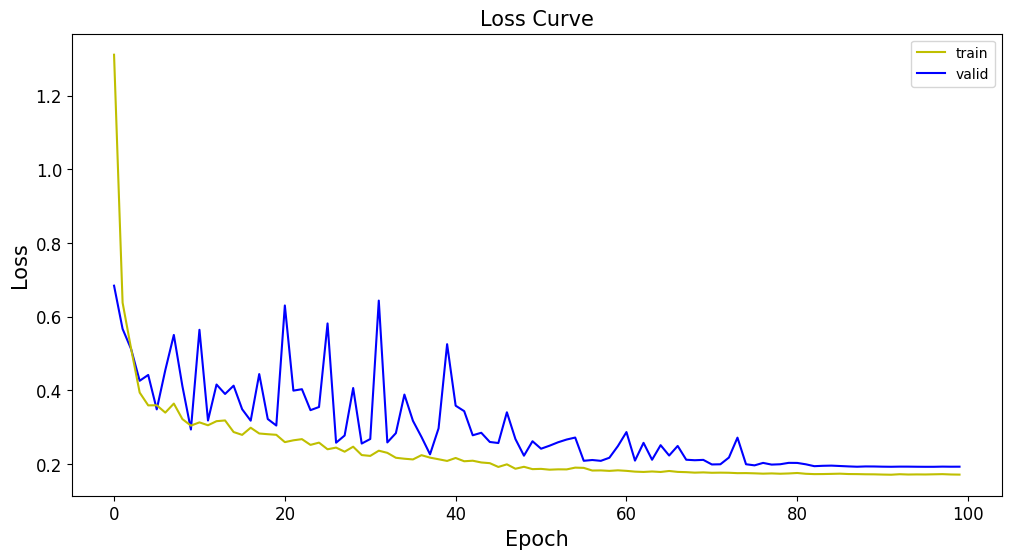

In [24]:
t.show_learn_curve()

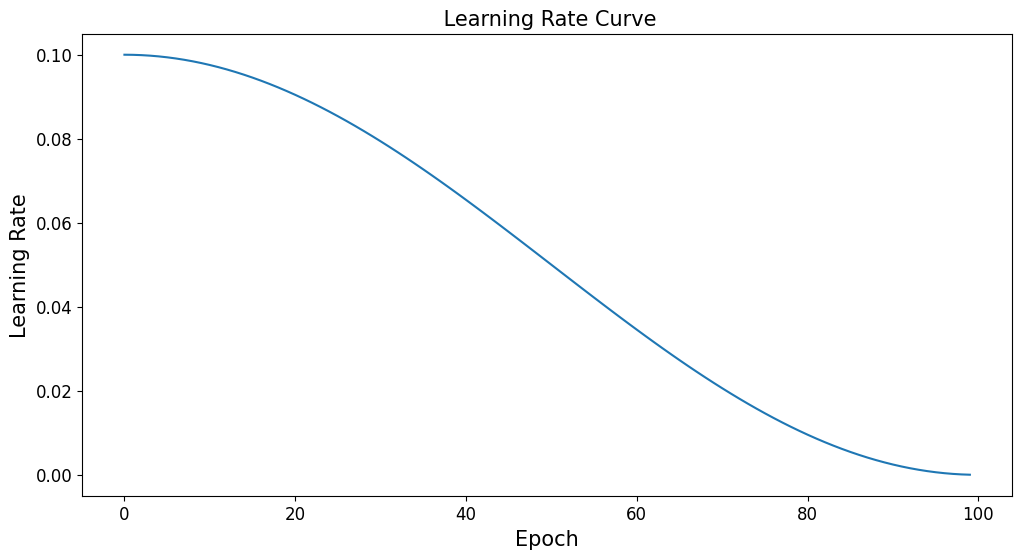

In [25]:
t.show_lr()

Then, use **show_result** to visual training results. The parameter **ti** is used to determine which target to view. If the target corresponds to regression task, the **parity plot** is plotted. If the target corresponds to the classification task, the **ROC curve** is drawn. When draw ROC curve, you also need to specify a dataset between 'valid' and 'test'.

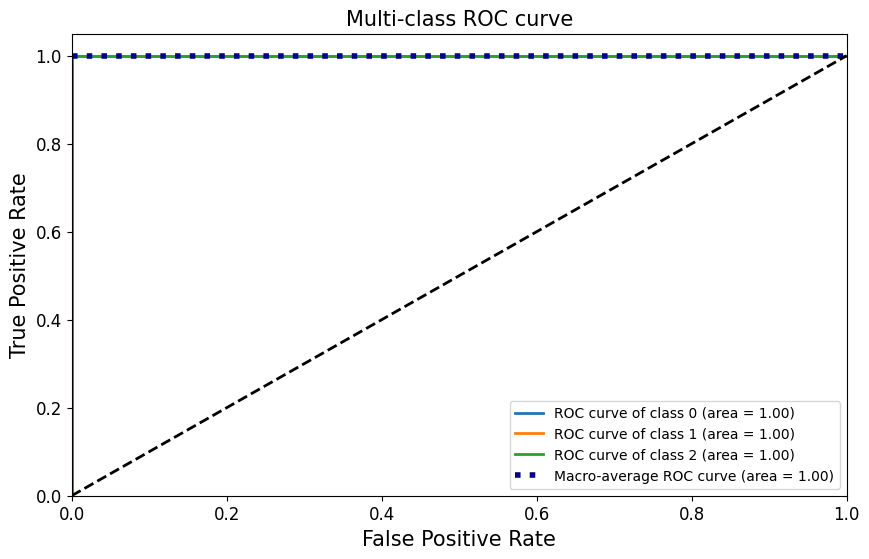

In [26]:
t.show_result(ti=0, dataset='test')

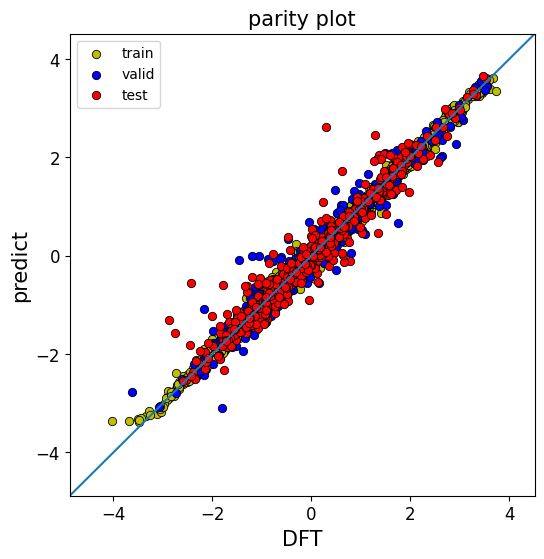

In [27]:
t.show_result(ti=2)

Using **calculate_static** to calculate metric for each dataset and each task.

In [28]:
t.calculate_static()

{'train': {'f1_0': 1.0,
  'ac_0': 1.0,
  'pc_0': 1.0,
  'rc_0': 1.0,
  'f1_1': 1.0,
  'ac_1': 1.0,
  'pc_1': 1.0,
  'rc_1': 1.0,
  'r2_2': 0.994396362817258,
  'mae_2': 0.06784402,
  'mse_2': 0.008145841,
  'rmse_2': 0.090254314},
 'valid': {'f1_0': 1.0,
  'ac_0': 1.0,
  'pc_0': 1.0,
  'rc_0': 1.0,
  'f1_1': 1.0,
  'ac_1': 1.0,
  'pc_1': 1.0,
  'rc_1': 1.0,
  'r2_2': 0.9574186510850258,
  'mae_2': 0.16668792,
  'mse_2': 0.06350535,
  'rmse_2': 0.2520027},
 'test': {'f1_0': 1.0,
  'ac_0': 1.0,
  'pc_0': 1.0,
  'rc_0': 1.0,
  'f1_1': 0.9979867385268659,
  'ac_1': 0.998,
  'pc_1': 0.9980084745762712,
  'rc_1': 0.998,
  'r2_2': 0.9371538241594592,
  'mae_2': 0.19158986,
  'mse_2': 0.094030686,
  'rmse_2': 0.30664423}}

You can also get a confusion matrix for each classification task by using **confusion_matrix**

In [29]:
cms, mcms = t.confusion_matrix(dataloader='test') # valid or test

In [30]:
cms

[array([[100,   0,   0,   0,   0],
        [  0, 102,   0,   0,   0],
        [  0,   0, 137,   0,   0],
        [  0,   0,   0, 135,   0],
        [  0,   0,   0,   0,  26]], dtype=int64),
 array([[206,   0,   0,   0],
        [  0,  26,   0,   0],
        [  0,   0,  32,   1],
        [  0,   0,   0, 235]], dtype=int64)]

Trained model can be saved by **save** on **Trainer**.  This saves both a **model file** and a **parameter dict file**. If you want to change the name of the saved model, modify the **name** attribute of the model after the model is defined.

In [31]:
t.save(path=r'data/example/model')

When you need to predict, use the **predict** method, enter a **Graph_data_loader** and it will return the predicted value. When there are classification tasks, The parameter **to_class** is used to make the predicted value output the class, and conversely the output value is the probability of a sampl to different class

In [32]:
yp = t.predict(Loader_test)
yp[:2]

array([[ 9.9999583e-01,  8.2861639e-08,  7.0753892e-08,  4.0196346e-06,
         4.9976303e-09,  1.0000000e+00,  1.7259956e-13,  8.3177965e-10,
         1.3534517e-11, -5.4280692e-01],
       [ 1.2275054e-04,  2.4730305e-04,  5.5848847e-07,  9.9962938e-01,
         3.8420379e-13,  9.9998856e-01,  1.1380504e-05,  2.2344537e-08,
         2.7765562e-08, -1.5767219e+00]], dtype=float32)

In [33]:
yp = t.predict(Loader_test, to_class=True)
yp[:2]

array([[ 0.       ,  0.       , -0.5428069],
       [ 3.       ,  0.       , -1.5767219]], dtype=float32)